In [1]:
import innvestigate
import tensorflow as tf
from pathlib import Path
import xarray as xr
from shared.training import split_data_on_participants, train_and_evaluate
from shared.normalization import *
from shared.generators import SAT1DataGenerator
import matplotlib.pyplot as plt
import numpy as np
from shared.data import SAT1_STAGES_ACCURACY

tf.compat.v1.disable_eager_execution()
from mne.viz import plot_topomap
from mne.io import read_info
from collections import defaultdict

2023-10-07 11:23:01.557493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 11:23:02.332035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

train_data, val_data, test_data = split_data_on_participants(data, 60, norm_dummy)

In [3]:
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

In [38]:
model = tf.keras.models.load_model("models/cnn_base_new")


def model_modifier(model):
    model.layers[-1].activation = tf.keras.activations.linear


model_modifier(model)
analyzer = innvestigate.create_analyzer(
    "lrp.sequential_preset_a_flat", model, epsilon=1
)

2023-10-07 11:40:44.030640: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_74' id:3230 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_74}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](count_6, Identity_74)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [48]:
test_gen = SAT1DataGenerator(test_data)
test_items = defaultdict(list)
results = defaultdict(list)
results_combined = defaultdict(list)
for batch_idx in range(len(test_gen)):
    test_batch = test_gen.__getitem__(batch_idx)
    for item in test_batch[0]:
        # (154, 30) test sample
        item_label = item.labels.item()
        item_reshaped = item.data.reshape((1, 154, 30, 1))
        # Back to (154, 30)
        analysis = np.squeeze(analyzer.analyze(item_reshaped))
        analysis /= np.max(np.abs(analysis))
        # Get max activation sample
        max_sample_idx = np.argmax(np.sum(analysis, axis=1))
        max_activation_sample = analysis[max_sample_idx, :]
        max_activity = max_activation_sample * item[max_sample_idx, :]
        test_items[item_label].append(item[max_sample_idx, :])
        results[item_label].append(max_activation_sample)
        results_combined[item_label].append(max_activity)
        # Get mean activation
        # analysis[analysis == 0] = np.nan
        # item.data[item.data == 999] = np.nan
        # mean_activation = np.nanmean(analysis, axis=0)
        # mean_activity = np.nanmean(item.data, axis=0)
        # results[item_label].append(mean_activation)
        # test_items[item_label].append(mean_activity)
        # results_combined[item_label].append(mean_activation * mean_activity)

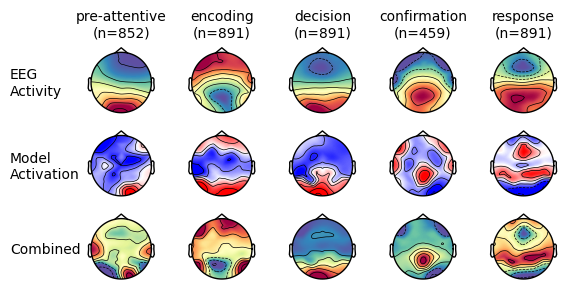

In [81]:
f, ax = plt.subplots(nrows=3, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 3))

for i, label in enumerate(SAT1_STAGES_ACCURACY):
    # print(k)
    label_results = np.array(test_items[label])
    n = len(test_items[label])
    mean_eeg_activity = np.mean(label_results, axis=0)
    ax[0, i].set_title(f"{label}\n(n={n})", fontsize=10)
    if i == 0:
        ax[0, i].text(-0.35, 0, 'EEG\nActivity', va='center', ha='left')
        ax[1, i].text(-0.35, 0, 'Model\nActivation', va='center', ha='left')
        ax[2, i].text(-0.35, 0, 'Combined', va='center', ha='left')
    # Raw EEG Activation
    plot_topomap(
        mean_eeg_activity,
        positions,
        axes=ax[0, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_eeg_activity), np.max(mean_eeg_activity)),
        sensors=False,
        contours=6,
    )
    # Model activity
    label_results = np.array(results[label])
    mean_importance = np.mean(label_results, axis=0)
    plot_topomap(
        mean_importance,
        positions,
        axes=ax[1, i],
        show=False,
        cmap="bwr",
        vlim=(np.min(mean_importance), np.max(mean_importance)),
        sensors=False,
        contours=6,
    )
    # Combined
    label_results = np.array(results_combined[label])
    mean_combined_importance = np.mean(label_results, axis=0)
    plot_topomap(
        mean_combined_importance,
        positions,
        axes=ax[2, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_combined_importance), np.max(mean_combined_importance)),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

(137, 30)
(157, 30)
(140, 30)
(67, 30)
(139, 30)


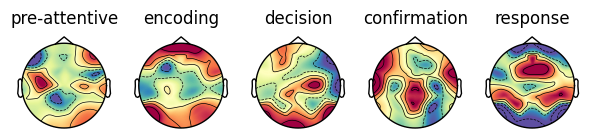

In [28]:
f, ax = plt.subplots(nrows=1, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 4))
mean_importances = np.zeros((len(SAT1_STAGES_ACCURACY), len(data.channels)))
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    # print(k)
    label_results = np.array(results[label])
    print(label_results.shape)
    mean_importance = np.mean(label_results, axis=0)
    mean_importances[i, :] = mean_importance
    # ax[i].set_title(label)
    # plot_topomap(
    #     mean_importance,
    #     positions,
    #     axes=ax[i],
    #     show=False,
    #     cmap="Spectral_r",
    #     vlim=(np.min(mean_importance), np.max(mean_importance)),
    #     sensors=False,
    #     contours=6,
    # )
mean_importances = (mean_importances - np.mean(mean_importances, axis=0)) / np.std(
    mean_importances, axis=0
)
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    ax[i].set_title(label)
    plot_topomap(
        mean_importances[i, :],
        positions,
        axes=ax[i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_importances[i, :]), np.max(mean_importances[i, :])),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

In [39]:
new_results = np.zeros((5, 200, 30))
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    label_results = np.array(results[label])
    new_results[i, 0 : label_results.shape[0], :] = label_results

In [40]:
new_results.shape

(5, 200, 30)

In [184]:
np.array(results["pre-attentive"])

(160, 30)

In [42]:
test_gen = SAT1DataGenerator(test_data)
test_batch = test_gen.__getitem__(0)
# 3 is encoding, 8 is encoding
test_item = test_batch[0][0]
print(test_item)

<xarray.DataArray 'data' (samples: 154, channels: 30)>
array([[-1.22915792e+01, -1.72746162e+01, -1.25034361e+01, ...,
         1.40857115e+01,  1.11860876e+01, -2.18632445e-01],
       [-1.63107796e+01, -2.28622246e+01, -1.52661533e+01, ...,
         1.84951839e+01,  1.77053204e+01,  3.97869158e+00],
       [-1.77319412e+01, -1.98306026e+01, -1.34106379e+01, ...,
         1.97935162e+01,  1.97225132e+01,  4.34355211e+00],
       ...,
       [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02]])
Coordinates:
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153
    stim      

In [25]:
test_item = test_item.data.reshape((1, 154, 30, 1))
analyzer = innvestigate.create_analyzer(
    "lrp.sequential_preset_a_flat", model, epsilon=1
)

In [29]:
analysis = analyzer.analyze(test_item)
# analysis /= np.max(np.abs(analysis))
analysis = np.squeeze(analysis)

In [35]:
np.mean(analysis, axis=0)

array([-7.32697081e-05,  4.15735522e-05,  1.87479982e-05, -4.43720273e-05,
        4.55263907e-05,  4.60022020e-05,  4.36655355e-05,  8.55890976e-05,
        1.10397828e-04,  5.57990716e-05,  9.09973605e-05,  1.82087497e-05,
        1.49110041e-04,  3.92322472e-05,  3.20738363e-05,  9.01224194e-05,
        4.14970600e-06, -5.53060954e-06,  2.46786803e-04,  1.39762065e-04,
       -6.42572513e-06,  1.62113301e-05, -1.24523749e-05, -1.20259404e-06,
        4.58549766e-05,  1.58014256e-04, -6.48970381e-05,  1.85949411e-05,
        1.66030586e-05,  1.08239095e-04], dtype=float32)

In [122]:
np.argmax(np.sum(analysis, axis=1))

2

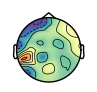

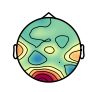

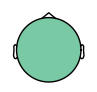

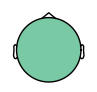

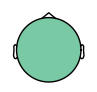

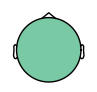

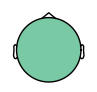

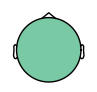

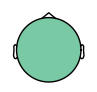

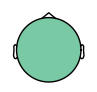

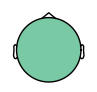

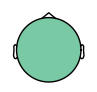

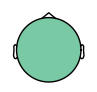

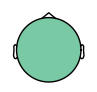

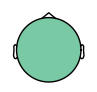

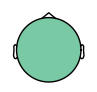

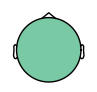

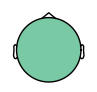

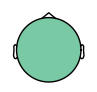

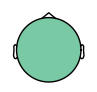

In [27]:
for i in np.arange(0, 20):
    plot_topomap(
        analysis[i, :],
        positions,
        show=True,
        cmap="Spectral_r",
        vlim=(np.min(analysis), np.max(analysis)),
        sensors=False,
        contours=6,
    )

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=len(labels_idx), figsize=(6, 4))
timesteps = np.arange(0, len(data.samples), 10)
for label_idx in labels_idx:
    activations_new_mean = np.mean(
        np.squeeze(activations[label_idx]) - np.mean(np.squeeze(activations)), axis=0
    )
    # activations_new_mean = np.mean(np.squeeze(activations[label_idx]), axis=0)
    vmin = np.min(activations_new_mean)
    vmax = np.max(activations_new_mean)
    ax[label_idx].set_title(data.labels[label_idx].item())
    plot_topomap(
        activations_new_mean,
        positions,
        axes=ax[label_idx],
        show=False,
        cmap="Spectral_r",
        vlim=(vmin, vmax),
        sensors=False,
        contours=0,
        names=data.channels.to_numpy(),
    )
    # plt.title(data.labels[label_idx].item())
plt.tight_layout()
plt.show()